In [2]:
'''%matplotlib widget
'''
import numpy as np
import pandas as pd
import random
import warnings
from __future__ import division
# import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from scipy.stats import norm
from scipy.stats import linregress
from __future__ import print_function
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection    
from statistics import mode

import random
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import pickle
from tqdm import tqdm
warnings.filterwarnings('ignore')


In [3]:
parameters = {  'Class': [0, 1, 2, 3, 4, 5],
                'Probability': [0.95, 0.015, 0.015, 0.01, 0.005, 0.005],
                'Sigma_xx': [0, 1, 1, 1, 1, 1],
                'Sigma_yy': [0, 1, 1, 1, 1, 1],
                'Sigma_xy': [0, 1, 1, 1, 1, 1],
                'Sigma_yx': [0, 1, 1, 1, 1, 1]}
parameters = {  'Class': [0, 1, 2, 3, 4, 5],
                'Probability': [0.95, 0.015, 0.015, 0.01, 0.005, 0.005],
                'Sigma_xx': [0, 1, 1.1, 1.2, 1.3, 1.5],
                'Sigma_yy': [0, 1, 1.1, 1.2, 1.3, 1.5],
                'Sigma_xy': [0, 1, 1, 1, 1, 1],
                'Sigma_yx': [0, 1, 1, 1, 1, 1]}
# df = pd.DataFrame(parameters)
# df.to_csv('defect_parameters.csv', index=False)

In [4]:
random.choices(parameters['Class'], parameters['Probability'])


[3]

In [5]:
data = pickle.load(open('maps/map_1.pkl', 'rb'))

In [6]:
with open('output.txt', 'w') as f:
    for key, value in data.items():
        f.write(f'{key}: {value}\n')
        #print('key is: ', key, ' and value is ', value)

In [7]:
def generate_map_defects(map_data, 
                        parameters = {  'Class': [0, 1, 2, 3, 4, 5],
                                        'Probability': [0.95, 0.015, 0.015, 0.01, 0.005, 0.005],
                                        'Sigma_xx': [0, 1, 1, 1, 1, 1],
                                        'Sigma_yy': [0, 1, 1, 1, 1, 1],
                                        'Sigma_xy': [0, 1, 1, 1, 1, 1],
                                        'Sigma_yx': [0, 1, 1, 1, 1, 1]}):

    defect_total = 0 
    extruded_points = 0
    persist = 0
    persist_class = 0
    for coord, state in dict(map_data).items():
        if state != None:
            if persist > 0:
                persist -= 1
                map_data[coord] = list(state) + [persist_class, 0, 0, 0, 0, 0, 0]
            else:
                extruded_points += 1
                defect_class = random.choices(parameters['Class'], parameters['Probability'])

                if defect_class[0] != 0:
                    defect_total += 1
                    persist = 5
                    persist_class = defect_class[0]
                    #print(persist_class)
                    # print('defect generated of class', defect_class)

                map_data[coord] = list(state) + [defect_class[0], 0, 0, 0, 0, 0, 0]
        else:
            del map_data[coord]

    with open('output_map.txt', 'w') as f:
        for key, value in map_data.items():
            f.write(f'{key}: {value}\n')

    print(extruded_points, defect_total)
    return map_data

map_classed = generate_map_defects(data.copy())

521227 25859


In [81]:
def generate_map_observed(map_classed, parameters, observation_chance=0.98):
    map_observed = {}
    error = 0
    for coord, state in map_classed.items():
        val = random.random()
        if val < observation_chance:
            map_observed[coord] = state
        else:
            state_error = (state[0], state[1], random.choices(parameters['Class'])[0])
            map_observed[coord] = state_error
            error += 1
    print(error)
    with open('output_map_observed.txt', 'w') as f:
        for key, value in map_observed.items():
            f.write(f'{key}: {value}\n')

    return map_observed
    
map_observed = generate_map_observed(map_classed, parameters)

12937


In [82]:
def multivariate_gaussian( pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

In [83]:
map_observed_defect = {}
for coord, state in map_observed.items():
    if state[2] != 0:
        map_observed_defect[coord] = state

In [84]:
map_classed_defect = {}
for coord, state in map_classed.items():
    if state[2] != 0:
        map_classed_defect[coord] = state + [0, 0, 0, 0, 0, 0]

In [85]:
with open('output_map_classed_defect.txt', 'w') as f:
    for key, value in map_classed_defect.items():
        f.write(f'{key}: {value}\n')

In [86]:
max_x = 0
max_y = 0
for coord, state in map_classed.items():
    if coord[0] > max_x:
        max_x = coord[0]
    if coord[1] > max_y:
        max_y = coord[1]

print(max_x, max_y)


379.3 189.6


In [9]:
bound = np.zeros(shape=(380, 190))
bound_obs = np.zeros(shape=(380, 190))
span = np.linspace(-5, 5, 11)/10


In [11]:
# OBSERVING THE DATA

observation_chance = 0.98
# in x
for coord, state in data.items():
    span_x = span + coord[0]
    span_y = span + coord[1]
    for x in range(len(span_x)):
            for y in range(len(span_y)):
                # Try the key, if failed pass
                try:
                    state = map_classed[(span_x[x], span_y[y])]
                    distance = np.sqrt((coord[0]-span_x[x])**2 + (coord[1]-span_y[y])**2)
                    val = random.random()
                    if val < observation_chance * (1 - distance):
                        state_obs = state[2]
                    else:
                        state_obs = random.choices(parameters['Class'])[0]
                    map_classed[(span_x[x], span_y[y])][3 + state_obs] += 1
                except:
                    pass


        

In [12]:
with open('output_map_observed.txt', 'w') as f:
    for key, value in map_classed.items():
        f.write(f'{key}: {value}\n')

In [90]:
# DOWNSAMPLING THE DATA

# in x
observation_chance = .98
for i in range(len(bound)):
    # in y
    for j in range(len(bound[0])):
        span_x = span + i
        span_y = span + j
        # Go through all possible keys
        obs = []
        n = 0
        for x in range(len(span_x)):
            for y in range(len(span_y)):
                # Try the key, if failed pass
                try:
                    state = map_classed[(span_x[x], span_y[y])]

                    val = random.random()
                    if val < observation_chance*():
                        state_obs = state[2]
                    else:
                        state_obs = random.choices(parameters['Class'], parameters['Probability'])[0]
                    obs.append(state_obs)
                    n += 1
                except:
                    pass
        # print('finished point', i, j, 'with #obs = ', n)
        try:
            obs_max = mode(obs)
            bound[i][j] = obs_max
            bound_obs[i][j] = n
            if obs_max != 0:
                print(obs_max, 'at ', i, j)
        except:
            bound[i][j] = None
            bound_obs[i][j] = 0
        

SyntaxError: invalid syntax (1611937058.py, line 20)

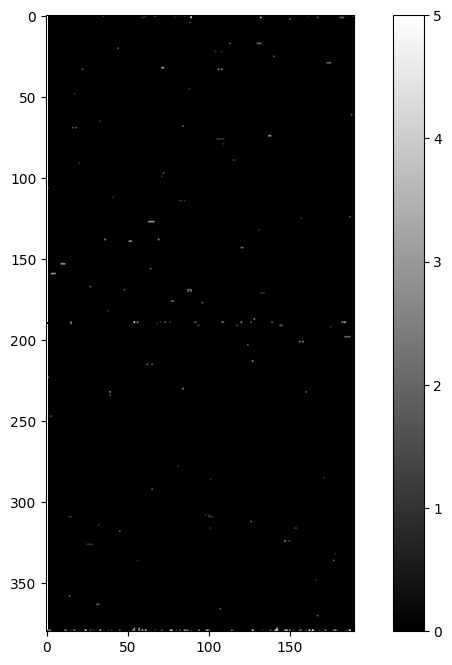

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a random 190x200 numpy array with values from 1-5
# array = np.random.randint(low=1, high=6, size=(190, 200))

# Display the array as an image
fig = plt.figure(figsize=(10, 8))
plt.imshow(bound, cmap='gray', vmin=0, vmax=5)
plt.colorbar()
plt.show()
fig.savefig('real_map.png', dpi=1200)

In [ ]:
np.savetxt("bound.txt", bound, fmt='%.0f', delimiter=",")

KeyboardInterrupt: 

In [ ]:
map_classed

{(0.0, 0.0): ('arm_1', 'G1', 0),
 (0.0, 0.1): ('arm_1', 'G1', 0),
 (0.0, 0.2): ('arm_1', 'G1', 0),
 (0.0, 0.3): ('arm_1', 'G1', 0),
 (0.0, 0.4): ('arm_1', 'G1', 0),
 (0.0, 0.5): ('arm_1', 'G1', 0),
 (0.0, 0.6): ('arm_1', 'G1', 0),
 (0.0, 0.7): ('arm_1', 'G1', 0),
 (0.0, 0.8): ('arm_1', 'G1', 0),
 (0.0, 0.9): ('arm_1', 'G1', 0),
 (0.0, 1.0): ('arm_1', 'G1', 0),
 (0.0, 1.1): ('arm_1', 'G1', 0),
 (0.0, 1.2): ('arm_1', 'G1', 0),
 (0.0, 1.3): ('arm_1', 'G1', 0),
 (0.0, 1.4): ('arm_1', 'G1', 0),
 (0.0, 1.5): ('arm_1', 'G1', 0),
 (0.0, 1.6): ('arm_1', 'G1', 0),
 (0.0, 1.7): ('arm_1', 'G1', 0),
 (0.0, 1.8): ('arm_1', 'G1', 0),
 (0.0, 1.9): ('arm_1', 'G1', 0),
 (0.0, 2.0): ('arm_1', 'G1', 0),
 (0.0, 2.1): ('arm_1', 'G1', 0),
 (0.0, 2.2): ('arm_1', 'G1', 0),
 (0.0, 2.3): ('arm_1', 'G1', 0),
 (0.0, 2.4): ('arm_1', 'G1', 0),
 (0.0, 2.5): ('arm_1', 'G1', 0),
 (0.0, 2.6): ('arm_1', 'G1', 0),
 (0.0, 2.7): ('arm_1', 'G1', 0),
 (0.0, 2.8): ('arm_1', 'G1', 0),
 (0.0, 2.9): ('arm_1', 'G1', 0),
 (0.0, 3.0

In [ ]:
class LayerInstance():
    r""""Creates a layer simulation instance which runs with the execute function.
    
    Args:
        args: 
        kwargs: (unused)

    Shape:
        .csv file of nxm point space

    Examples::

        >>> instance = LayerInstance()
        >>>
    
    """
    def __init__(self, defect_parameters=pd.read_csv("defect_parameters.csv"), observation_chance = 0.70, real_points = pd.read_csv("temp data.csv")):
        self.seed = np.random.randint(0, 100)
        self.points = real_points
        self.defect_parameters = defect_parameters

        self.observed_points = pd.DataFrame({   'X': [],
                                                'Y': [],
                                                'sightings': [],
                                                'set class': [],
                                                'class 0': [],
                                                'class 1': [],
                                                'class 2': [],
                                                'class 3': [],
                                                'class 4': [],
                                                'class 5': []})
        self.observation_chance = observation_chance

        print("Initialized with seed", self.seed)

    def observe_points(self):
        classes = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']

        # Iterate over all real points to get observations
        for point in range(len(self.points)):
            # Observe the class correctly or randomly
            np.random.seed(self.seed+point)
            if np.random.rand() < self.observation_chance:
                observed_class = self.points['Class'][point]
            else:
                np.random.seed(self.seed+point*2)
                observed_class = np.random.randint(0, 5)
            #print(observed_class)

            # Check to see if the point exists, if it did add obs. otherwise new point
            if (self.points['X'][point] in self.observed_points['X'].values and self.points['Y'][point] in self.observed_points['Y'].values):
                location = np.where((self.observed_points['X'].isin([self.points['X'][point]])) & 
                                    (self.observed_points['Y'].isin([self.points['Y'][point]])))
                self.observed_points['class ' + str(observed_class)][location[0]] += 1
                self.observed_points['sightings'][location[0]] +=  1

            else:
                # Append a new point if it has not been observed already
                data = pd.DataFrame({   'X': self.points['X'][point],
                                        'Y': self.points['Y'][point],
                                        'class ' + str(observed_class): [1]})
                self.observed_points = self.observed_points.append(pd.DataFrame(data), ignore_index=True)
                self.observed_points = self.observed_points.fillna(0)
                self.observed_points['sightings'][point] +=  1
        
        # Set obs. class as max from list, or random from top choices
        self.observed_points.reset_index()
        for point in range(len(self.observed_points)):
            # Get the max observations and locations
            max_obs = max(self.observed_points.loc[point, classes])
            mask = self.observed_points.loc[point, classes] == max_obs
            mask = mask.reset_index(drop=True)

            if len(mask.index[mask]) > 1:
                choice = np.random.choice(mask.index[mask])
            else:
                choice = mask.index[mask][0]

            self.observed_points['set class'][point] = choice

        print(self.observed_points)
        return

    def get_sd(self):
        for point in range(len(self.observed_points)):
            #point_class = self.ob
            #point_sd = [self.defect_parameters[]
            sd_prime = 1

        return

    def plot_likelihood(self):
        if self.targetsPosterior.empty:
            currentTargets = self.targetsObservedT1
            
        else:
            currentTargets = self.targetsPosterior
        fig, ax = plt.subplots(figsize=(10,10))
        ax.scatter(self.targetObjectiveArray['X Location'], self.targetObjectiveArray['Y Location'], color='r')
        ax.scatter(self.missileLocationArray['X Location'], self.missileLocationArray['Y Location'], color='black')
        for t in range(len(self.targetObjectiveArray)):
            plt.annotate(t, xy=(self.targetObjectiveArray['X Location'][t]+1, self.targetObjectiveArray['Y Location'][t]+1))

        for i in range(len(self.missileLocationArray)):
            circle = mpatches.Circle((self.missileLocationArray['X Location'][i], self.missileLocationArray['Y Location'][i]), missile_observation_radius, color='black', fill=False, label=i)
            ax.add_patch(circle)
            ax.set_label(i)
            plt.annotate(i, xy=(self.missileLocationArray['X Location'][i]+2, self.missileLocationArray['Y Location'][i]+2))

        plt.title('Coordinates at height ' + str(self.missileHeight))
        plt.xlim([0, 100])
        plt.ylim([0, 100])

        fig.savefig('Starting Coordinates' +self.saveTag + str(self.caseSeed) + str(int(missile_height)) + '.png', bbox_inches='tight', dpi=300)

        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(2,1,1,projection='3d')
        plt.title('Likelihood Distribution at height ' + str(self.missileHeight))
        ax2 = fig.add_subplot(2,1,2,projection='3d')
        Z_total = 0
        for i in range(len(currentTargets)):
            temp_target_index = i
            # Creat the meshgrid
            X, Y = np.meshgrid(self.gridZerosX, self.gridZerosY)
            pos = np.empty(X.shape + (2,))
            pos[:, :, 0] = X
            pos[:, :, 1] = Y

            mu = np.array([currentTargets['X Location'][temp_target_index], currentTargets['Y Location'][temp_target_index]])
            Sigma = np.array([[ currentTargets['SDx'][temp_target_index]**2 , 0], [0,  currentTargets['SDy'][temp_target_index]**2]])

            Z = self.multivariate_gaussian(pos, mu, Sigma)
            Z = Z * currentTargets['Target Class'][i]
            Z_total = np.add(Z_total, Z)
        ax2.contourf(X, Y, Z_total, zdir='z', offset=0, cmap=cm.viridis)
        ax1.plot_surface(X, Y, Z_total, rstride=3, cstride=3, linewidth=1, antialiased=True,
                        cmap=cm.viridis)

        for n in range(len(currentTargets)):
            ax2.scatter(currentTargets['X Location'][n], currentTargets['Y Location'][n], 2, c='red')
        for m in range(len(self.missileLocationArray)):
            ax2.scatter(self.missileLocationArray['X Location'][m], self.missileLocationArray['Y Location'][m], self.missileLocationArray['Z Location'][m], c='black')

        ax1.view_init(55,-70)
        #viridis
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_zticks([])

        ax1.set_xlabel('X Location (meters)')
        ax1.set_ylabel('Y Location (meters)')
        ax2.view_init(90, 270)
        ax2.grid(False)
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_zticks([])
        ax2.set_xlabel('X Location (meters)')
        ax2.set_ylabel('Y Location (meters)')
        fig.savefig('Likelihood' + self.saveTag + str(self.caseSeed) + str(int(missile_height)) + '.png', bbox_inches='tight', dpi=300)
        plt.show()
        return

instance = LayerInstance()

instance.observe_points()


Initialized with seed 87
     X    Y  sightings  set class  class 0  class 1  class 2  class 3  \
0  1.0  1.0        1.0        0.0      1.0      0.0      0.0      0.0   
1  2.0  1.0        2.0        2.0      0.0      1.0      1.0      0.0   
2  3.0  2.0        1.0        0.0      1.0      0.0      0.0      0.0   
3  4.0  2.0        1.0        2.0      0.0      0.0      1.0      0.0   
4  5.0  3.0        1.0        3.0      0.0      0.0      0.0      1.0   

   class 4  class 5  
0      0.0      0.0  
1      0.0      0.0  
2      0.0      0.0  
3      0.0      0.0  
4      0.0      0.0  


In [ ]:
instance = LayerInstance()

instance.observe_points()

In [ ]:
max(defect_parameters.loc[1, ['Class', 'Probability']].values)

1.0